In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListTusz
from lib.signals import EegProcessorTusz
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import IWasobi, EogDenoiser, CanonicalCorrelation, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaiat/s008_2012/01_tcp_ar/aaaaaiat_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
256.0
(34, 153856)
2025-02-25 23:31:08,492 - root - INFO - Recording contains channels = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG C3P-REF', 'EEG C4P-REF', 'EEG SP1-REF', 'EEG SP2-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG 31-REF', 'EEG 32-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR']


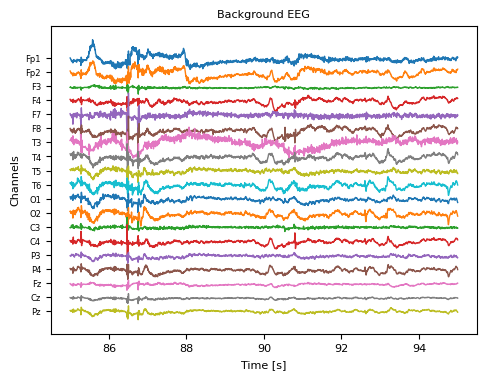

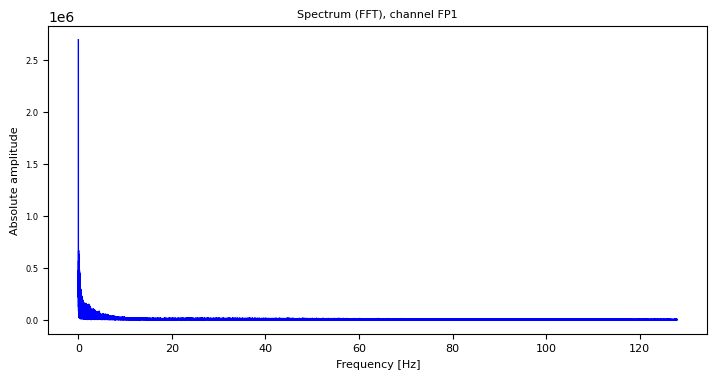

In [2]:
PATIENT = "aaaaaiat"
FILENAME = "aaaaaiat_s008_t000"
PERIOD = [85, 95]

###########################################################
metadata = MetadataListTusz()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorTusz(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

In [3]:
print(processor._data.shape)
print(processor.sampling_frequency)
print(current_metadata)

(19, 153856)
256.0
{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaiat/s008_2012/01_tcp_ar/aaaaaiat_s008_t000.edf', 'seizures': [(0.0, 0.0, 'bckg'), [520.3324, 599.99, 'fnsz']]}


### * Re-referencing to average reference

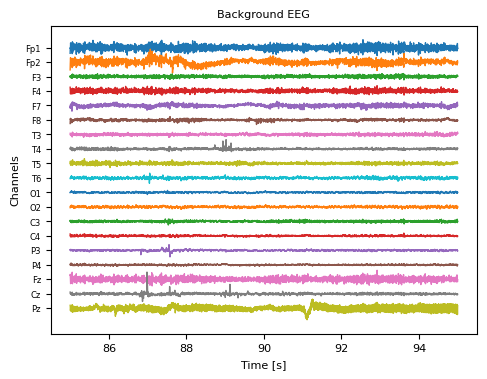

In [3]:
###########################################################
processor.rereference_to_average()

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Resample the EEG to 256Hz

2025-02-20 23:26:57,487 - root - INFO - Dowsampling factor is = 2


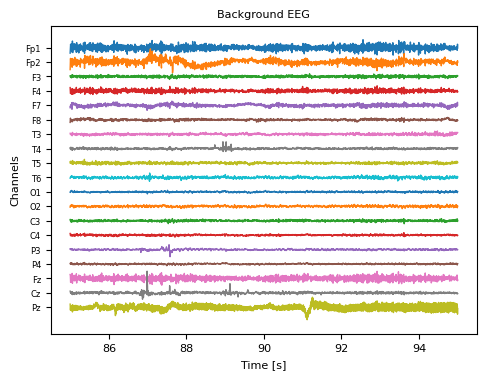

In [4]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)


### * Remove the drift noise, high frequency oscillations, power line noise

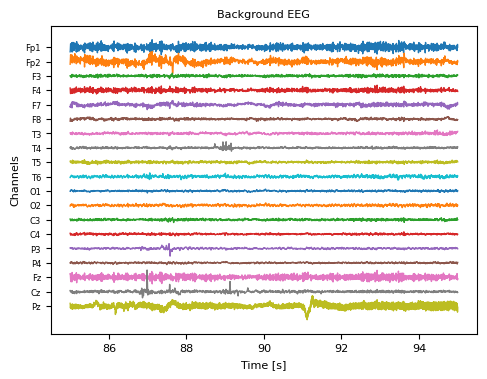

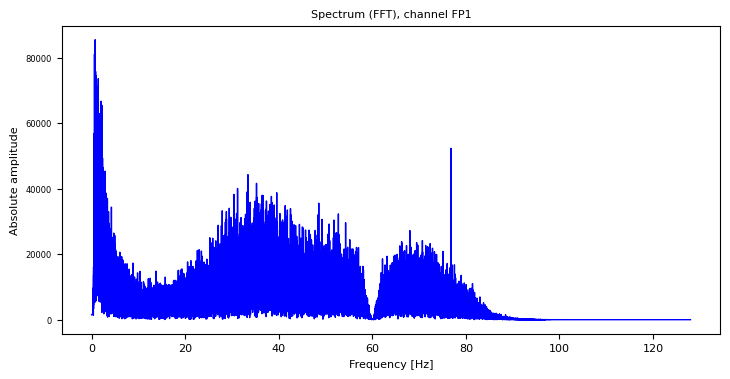

In [5]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

### * Separated sources using iWASOBI

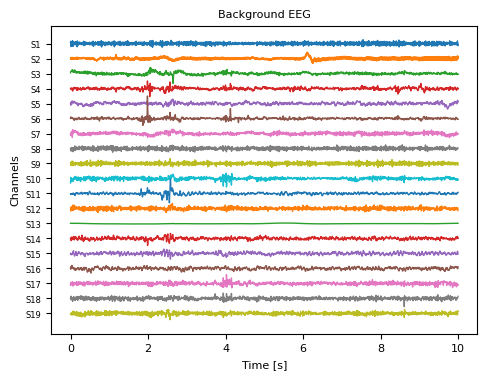

Source = 1, fd = 6.557897173550969
Source = 2, fd = 6.758360219606513
Source = 3, fd = 5.853350062275966
Source = 4, fd = 5.943895424295753
Source = 5, fd = 5.751580180563274
Source = 6, fd = 5.686134682065774
Source = 7, fd = 6.296382062980919
Source = 8, fd = 6.585150044695931
Source = 9, fd = 6.583518463894434
Source = 10, fd = 6.219029528239089
Source = 11, fd = 5.424821200699569
Source = 12, fd = 6.502513977591325
Source = 13, fd = 1.941970353478585
Source = 14, fd = 5.775801541793844
Source = 15, fd = 5.759253841441617
Source = 16, fd = 5.631472363043381
Source = 17, fd = 6.337764545030378
Source = 18, fd = 6.309080111682213
Source = 19, fd = 6.460321744647303
Done!
2025-02-20 23:27:27,051 - root - INFO - Number of sources to be removed = 1


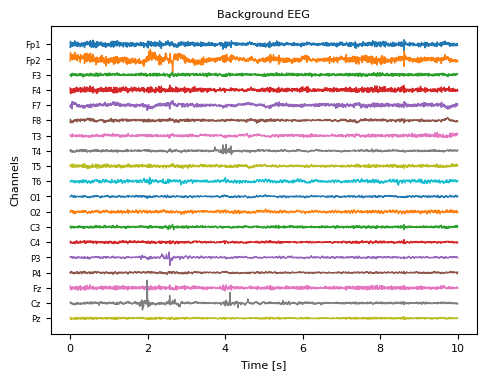

In [7]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eog_denoiser = EogDenoiser()
eog_denoiser.fit_fractal_dimensions(eeg_sources)
print(eog_denoiser)

eeg_sources = eog_denoiser.remove_low_dimension_sources([0, 3])

###########################################################
eeg_sources[0, :] = 0
eeg_sources[1, :] = 0
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

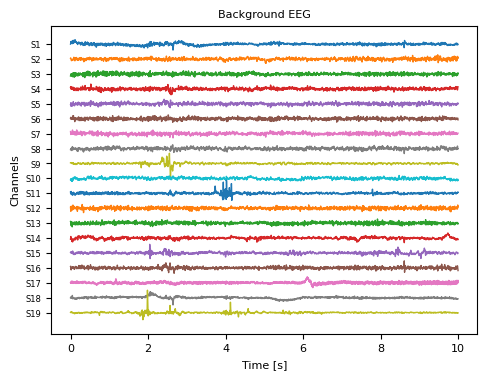

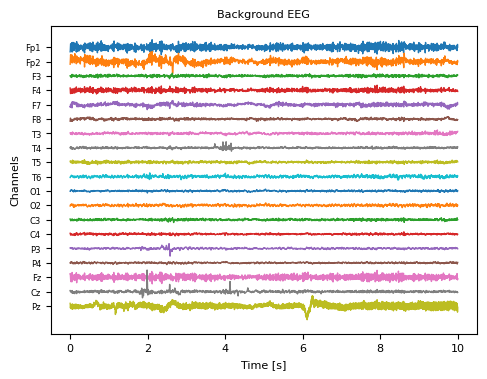

In [8]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
#eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

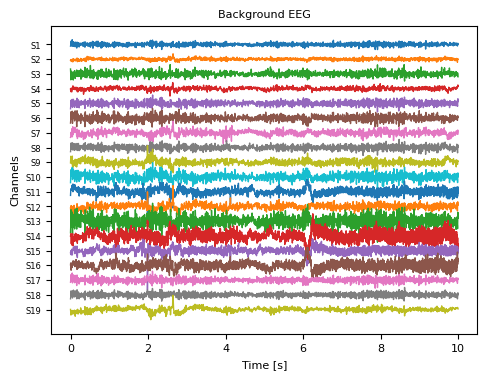

Source = 1, fd = 6.629239356619249
Source = 2, fd = 4.775876030545148
Source = 3, fd = 1.1576408785797978
Source = 4, fd = 2.8426303152010366
Source = 5, fd = 2.568598548383046
Source = 6, fd = 4.480515812553955
Source = 7, fd = 10.53052858137432
Source = 8, fd = 3.4489373988293552
Source = 9, fd = 12.0887203498297
Source = 10, fd = 5.774346140778013
Source = 11, fd = 9.012666268156286
Source = 12, fd = 9.170490968865321
Source = 13, fd = 2.3125418740226045
Source = 14, fd = 8.26230490396335
Source = 15, fd = 9.901442993031084
Source = 16, fd = 6.757300639849743
Source = 17, fd = 5.528489494642749
Source = 18, fd = 3.437340982388935
Source = 19, fd = 7.05218807196451
Done!
2025-02-20 23:30:32,207 - root - INFO - Number of sources to be removed = 3


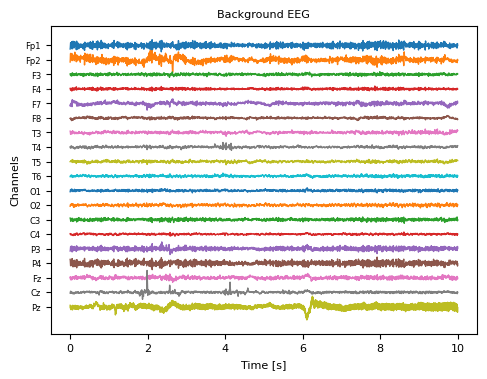

In [15]:
bsscca = CanonicalCorrelation()
eeg_sources = bsscca.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                      PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
emg_denoiser = EmgDenoiser(sampling_frequency=processor.sampling_frequency)
emg_denoiser.fit_psd_ratio(eeg_sources)
print(emg_denoiser)

eeg_sources = emg_denoiser.remove_low_ratio_sources([0, 3])

###########################################################
clean_eeg = bsscca.inverse_transform(eeg_sources)
plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Stationarity tests (KPPS and ADF)

In [5]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[15, :4000])

2025-02-21 00:26:20,868 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-02-21 00:26:21,172 - root - INFO - ADF test, null hyphotesis was rejected, p_value = 5.513643208619215e-11, significance level = 0.05
2025-02-21 00:26:21,186 - root - INFO - The time serie is stationary
